In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d salader/dogs-vs-cats

100% 1.06G/1.06G [00:51<00:00, 22.5MB/s]
100% 1.06G/1.06G [00:51<00:00, 22.2MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.regularizers import l2

In [6]:
# this is the augmentation configuration we will use for training
batch_size=24
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'content/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '/content/train',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        '/content/test',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


# New Section

In [7]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
# Freeze the convolutional layers to prevent updating their weights during training
for layer in base_model.layers:
    layer.trainable = False
# Create a new model on top of the pre-trained base model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128,activation='relu',kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu',kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid',kernel_regularizer=l2(0.01)))
model.summary()


58889256/58889256 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                82

In [8]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [9]:
history = model.fit(train_generator,epochs=10,validation_data=validation_generator)

Epoch 1/10
834/834 [==============================] - 177s 201ms/step - loss: 0.9787 - accuracy: 0.8468 - val_loss: 0.5063 - val_accuracy: 0.8678
Epoch 2/10
834/834 [==============================] - 166s 199ms/step - loss: 0.4946 - accuracy: 0.8569 - val_loss: 0.6919 - val_accuracy: 0.7152
Epoch 3/10
834/834 [==============================] - 168s 201ms/step - loss: 0.4272 - accuracy: 0.8604 - val_loss: 0.3480 - val_accuracy: 0.8844
Epoch 4/10
834/834 [==============================] - 168s 201ms/step - loss: 0.3996 - accuracy: 0.8634 - val_loss: 0.3693 - val_accuracy: 0.8826
Epoch 5/10
834/834 [==============================] - 169s 202ms/step - loss: 0.3888 - accuracy: 0.8706 - val_loss: 0.3213 - val_accuracy: 0.8976
Epoch 6/10
834/834 [==============================] - 167s 200ms/step - loss: 0.4093 - accuracy: 0.8668 - val_loss: 0.3678 - val_accuracy: 0.8968
Epoch 7/10
834/834 [==============================] - 165s 198ms/step - loss: 0.3950 - accuracy: 0.8683 - val_loss: 0.3321 -

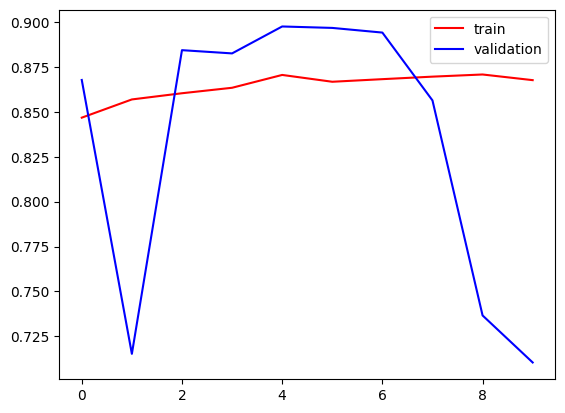

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

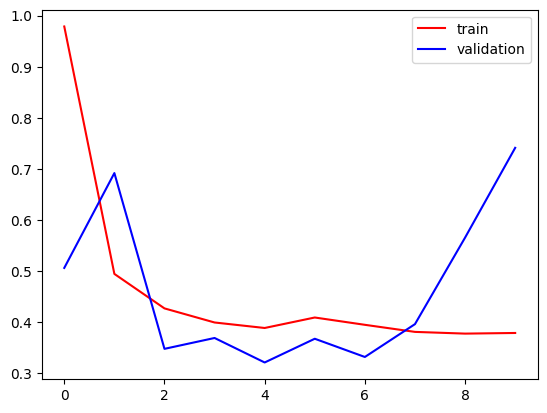

In [11]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()